# Contexto

Este projeto foi desenvolvido como parte do desafio do **IADT — Fase 1**. O objetivo é desenvolver modelos preditivos para estimar os custos médicos cobrados por seguros de saúde.

Para isso, usamos um dataset obtido na plataforma **Kaggle**, disponível no repositório [Healthcare Insurance Expenses](https://www.kaggle.com/datasets/arunjangir245/healthcare-insurance-expenses), com os seguintes atributos:

- `age`: idade da pessoa segurada.
- `sex`: gênero (masculino ou feminino) da pessoa segurada.
- `bmi`: índice de Massa Corporal.
- `children`: número de crianças dependentes.
- `smoker`: se a pessoa segurada é fumante.
- `region`: área geográfica de cobertura.
- `charges`: custos médicos cobrados por seguros de saúde da pessoa segurada.


Trata-se de um problema de **regressão supervisionada**, com variável target `charges`, que abordaremos com modelos lineares e baseados em árvores de decisão:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- Ordinary Least Squares (OLS)


# Setup

## Instalação de Dependências

In [1]:
# Instalação das bibliotecas necessárias para o projeto
! pip install --quiet pandas numpy matplotlib seaborn scikit-learn statsmodels joblib ipywidgets

## Importação de Bibliotecas

In [2]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Pré-processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Validação e avaliação
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

# Estatística
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Salvamento e carregamento de modelos treinados
import joblib

In [3]:
# Carrega o dataset

df = pd.read_csv("insurance.csv")

assert not df.empty, "Dataset não foi carregado corretamente"

# Exploração de Dados

Nesta etapa, buscamos compreender a estrutura e características principais do conjunto de dados. A análise inclui:

- Dimensões do dataset
- Tipos de variáveis
- Valores ausentes
- Estatísticas descritivas
- Visualizações iniciais para facilitar a interpretação inicial


In [4]:
# Retorna a dimensionalidade do DataFrame.
df.shape

(1338, 7)

💡 O dataset possui 1338 linhas (registros) e 7 colunas (variáveis).


In [5]:
# Exibe informações gerais do dataset: tipos de dados, contagem de valores não nulos e uso de memória.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


💡 O dataset não possui valores nulos, o que indica que ele já foi previamente limpo.

As variáveis categóricas são:

- `sex`
- `smoker`
- `region`

As variáveis numéricas são:

- `age`
- `bmi`
- `children`
- `charges`


In [6]:
# Não é recomendado remover duplicados automaticamente neste caso porque pessoas diferentes podem
# ter as mesmas características (idade, IMC, filhos, etc.) e ainda assim gerar observações legítimas.

# df = df.drop_duplicates()
# df.duplicated().sum()

In [7]:
# Visualiza as 5 primeiras linhas do dataset para inspecionar amostras reais dos dados.
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
# Gera estatísticas descritivas para variáveis numéricas do dataset.
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


💡 A análise descritiva revela informações importantes sobre as variáveis numéricas.

Essas métricas permitem avaliar a simetria, a presença de outliers e a dispersão das variáveis — informações úteis para decisões de pré-processamento e modelagem.

| **Métrica**   | **Descrição**                                                  | **Exemplo**                                                                            |
| ------------- | -------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| `count`       | Número de valores não nulos na coluna.                         | Todas as colunas têm **1338 entradas**, indicando que o dataset está completo.         |
| `mean`        | Média aritmética dos valores.                                  | A média de IMC (`bmi`) é aproximadamente **30**, indicando uma tendência ao sobrepeso. |
| `std`         | Desvio padrão — indica o grau de dispersão em relação à média. | O desvio padrão de `charges` é elevado, mostrando grande variação nos custos médicos.  |
| `min` / `max` | Menor e maior valor observado na variável.                     | A idade (`age`) varia de **18 a 64 anos**, cobrindo uma população adulta.              |
| `25%`         | Primeiro quartil — 25% dos dados estão abaixo desse valor.     | 25% dos pacientes têm menos de **27 anos** (`age`), indicando uma população jovem.     |
| `50%`         | Mediana — ponto central da distribuição.                       | A mediana de `charges` é cerca de **9.400**, menor que a média, sugerindo assimetria.  |
| `75%`         | Terceiro quartil — 75% dos dados estão abaixo desse valor.     | 75% têm `charges` abaixo de **17.000**, indicando que os valores mais altos são raros. |


In [9]:
# Exibe estatísticas descritivas para variáveis categóricas.
df.describe(include=['object'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


💡 As estatísticas descritivas das variáveis categóricas revelam que:

- As colunas `sex` e `smoker` são binárias, com apenas duas categorias distintas.
- A coluna `region` possui 4 categorias, o que a caracteriza como categórica nominal.
- O campo `top` indica a categoria mais comum em cada variável, e `freq` mostra sua frequência — útil para entender o balanceamento das classes.


### Análises gráficas das variáveis

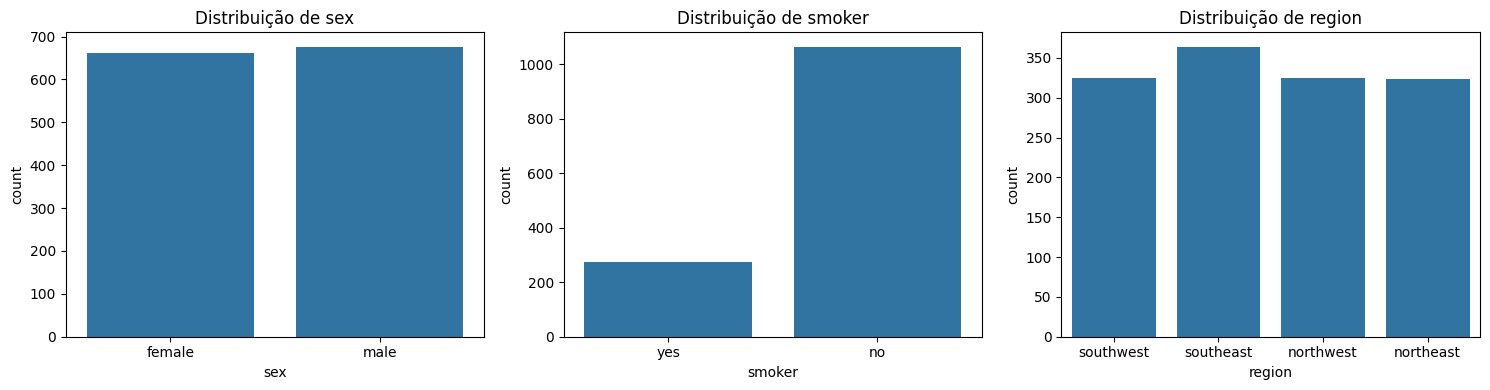

In [10]:
# Cria gráficos de barras para visualizar a frequência das categorias em 'sex', 'smoker' e 'region'.

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(data=df, x="sex", ax=axs[0])
axs[0].set_title("Distribuição de sex")

sns.countplot(data=df, x="smoker", ax=axs[1])
axs[1].set_title("Distribuição de smoker")

sns.countplot(data=df, x="region", ax=axs[2])
axs[2].set_title("Distribuição de region")

plt.tight_layout()
plt.show()

💡 A distribuição das variáveis categóricas mostra que:

- `sex`: A variável está aproximadamente balanceada entre masculino e feminino, o que evita viés de gênero no treinamento do modelo.
- `smoker`: A maior parte dos indivíduos são não-fumantes, indicando desequilíbrio de classes.
- `region`: As quatro regiões (`northeast`, `southeast`, `southwest`, `northwest`) têm distribuições similares, o que é positivo para generalização do modelo.

Essas análises ajudam a antecipar a necessidade de tratamento para desbalanceamentos (como em `smoker`) e a decidir o tipo de codificação adequada.


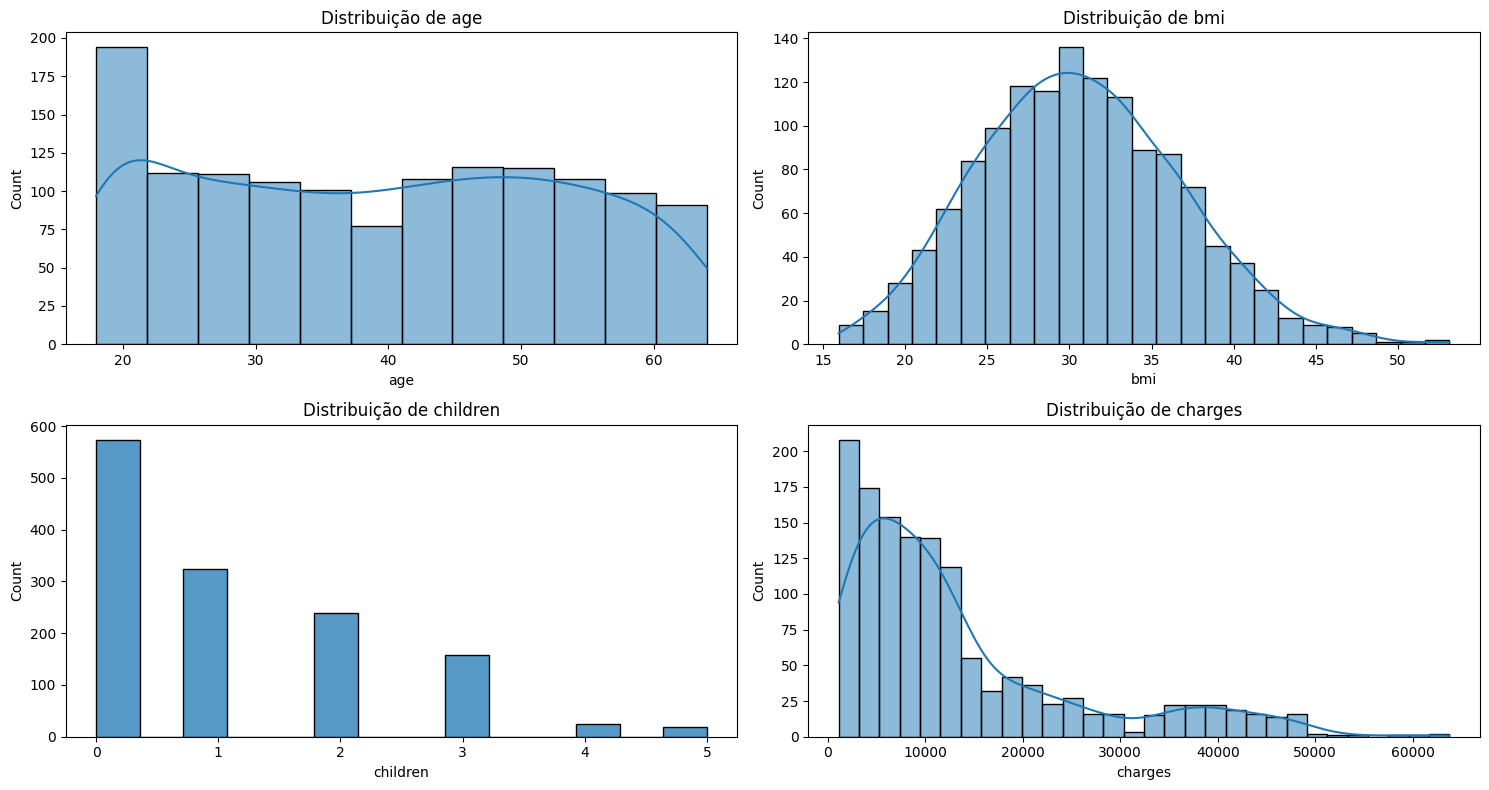

In [11]:
# Gera histogramas para visualizar a distribuição das variáveis numéricas: age, bmi, children e charges.

def plot_histogram(df, column, ax=None, kde=True):
    sns.histplot(df[column], kde=kde, ax=ax)
    ax.set_title(f"Distribuição de {column}")

cols = ["age", "bmi", "children", "charges"]
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for col, ax in zip(cols, axs.ravel()):
    kde_flag = False if col == "children" else True
    plot_histogram(df, col, ax, kde=kde_flag)
plt.tight_layout()
plt.show()

💡 A análise da distribuição das variáveis numéricas mostra que:

- **`age`**: A distribuição é ligeiramente assimétrica, o que pode influenciar o modelo a focar em custos de faixas etárias mais jovens.
- **`bmi`**: A distribuição é quase normal, mas com uma cauda à direita, indicando alguns casos de obesidade.
- **`children`**: A maioria dos indivíduos tem 0 ou poucos filhos, com poucos casos com 4 ou mais filhos.
- **`charges`**: A distribuição é muito assimétrica e possui uma cauda longa, indicando a presença de outliers — alguns poucos pacientes têm custos médicos extremamente altos.


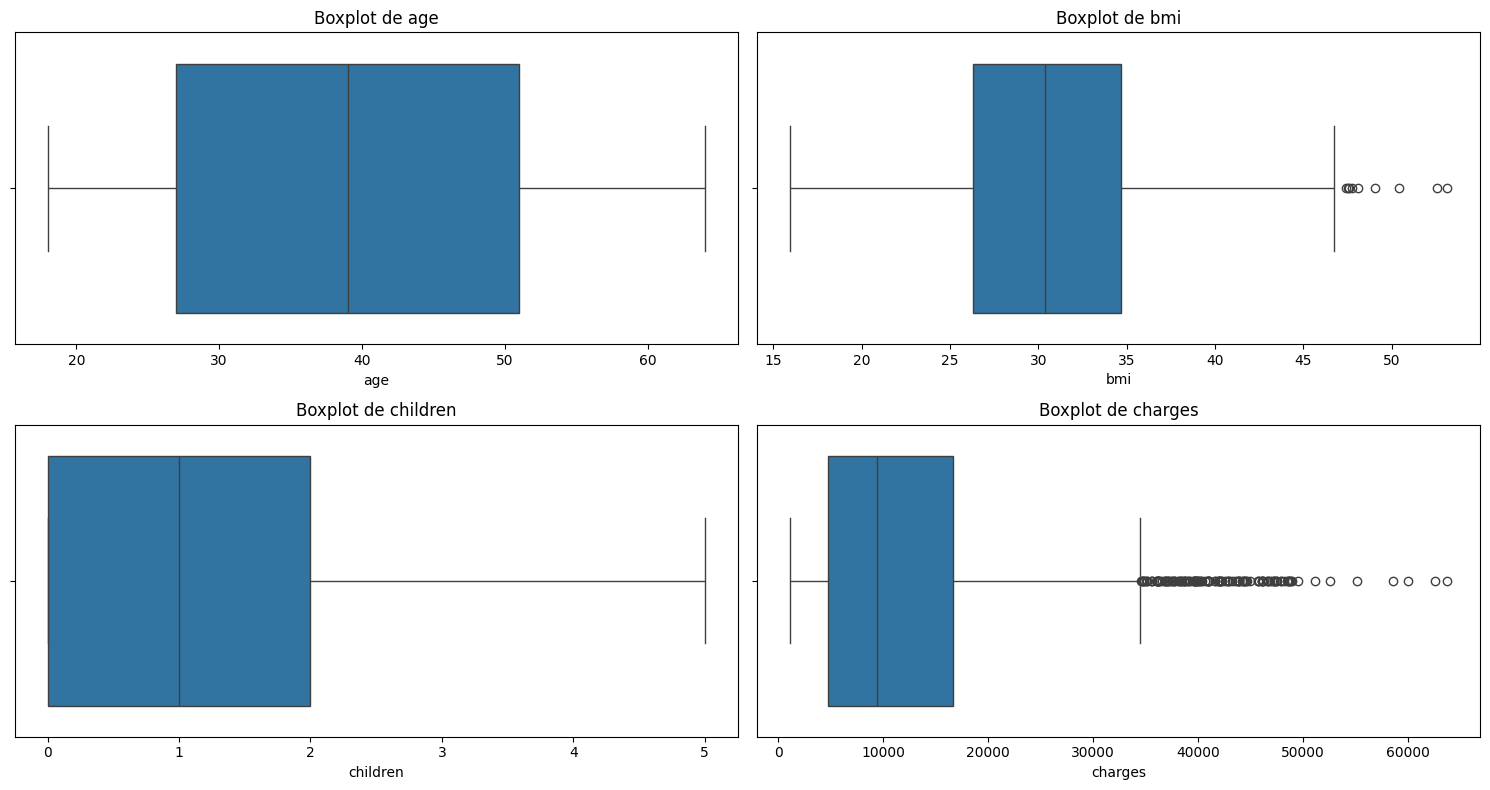

In [12]:
# Gera boxplots para inspecionar a distribuição e detectar outliers nas variáveis numéricas.

def plot_boxplot(df, column, ax=None):
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(f"Boxplot de {column}")

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for col, ax in zip(cols, axs.ravel()):
    plot_boxplot(df, col, ax)
plt.tight_layout()
plt.show()


💡 Os boxplots das variáveis numéricas revelam:

- **`age`**: Distribuição relativamente simétrica, sem outliers aparentes. A mediana está próxima ao centro da faixa etária.
- **`bmi`**: Leve assimetria à direita e presença de alguns outliers com IMC elevado, o que pode indicar indivíduos obesos.
- **`children`**: Como variável discreta, o boxplot mostra saltos em valores fixos. Não há outliers, mas a distribuição é claramente enviesada para baixo.
- **`charges`**: Forte assimetria à direita com diversos outliers, o que confirma a cauda longa observada no histograma. Esses valores extremos podem afetar o desempenho de modelos mais sensíveis à variância.


In [13]:
# Conta o número de outliers em cada variável numérica usando o método do intervalo interquartil (IQR).
outlier_counts = []

for col in df.select_dtypes(include=["float64", "int64"]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    # Calcula o intervalo interquartil (IQR) e os limites inferior e superior para detecção de outliers
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Conta o número de outliers fora dos limites definidos
    n_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    outlier_counts.append({
        "variável": col,
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "número de outliers": n_outliers
    })

display(pd.DataFrame(outlier_counts).sort_values(by="número de outliers", ascending=False))

,variável,Q1,Q3,IQR,número de outliers
3,charges,4740.28715,16639.912515,11899.625365,139
1,bmi,26.29625,34.693750,8.397500,9
0,age,27.00000,51.000000,24.000000,0
2,children,0.00000,2.000000,2.000000,0


### Análises gráficas das correlações

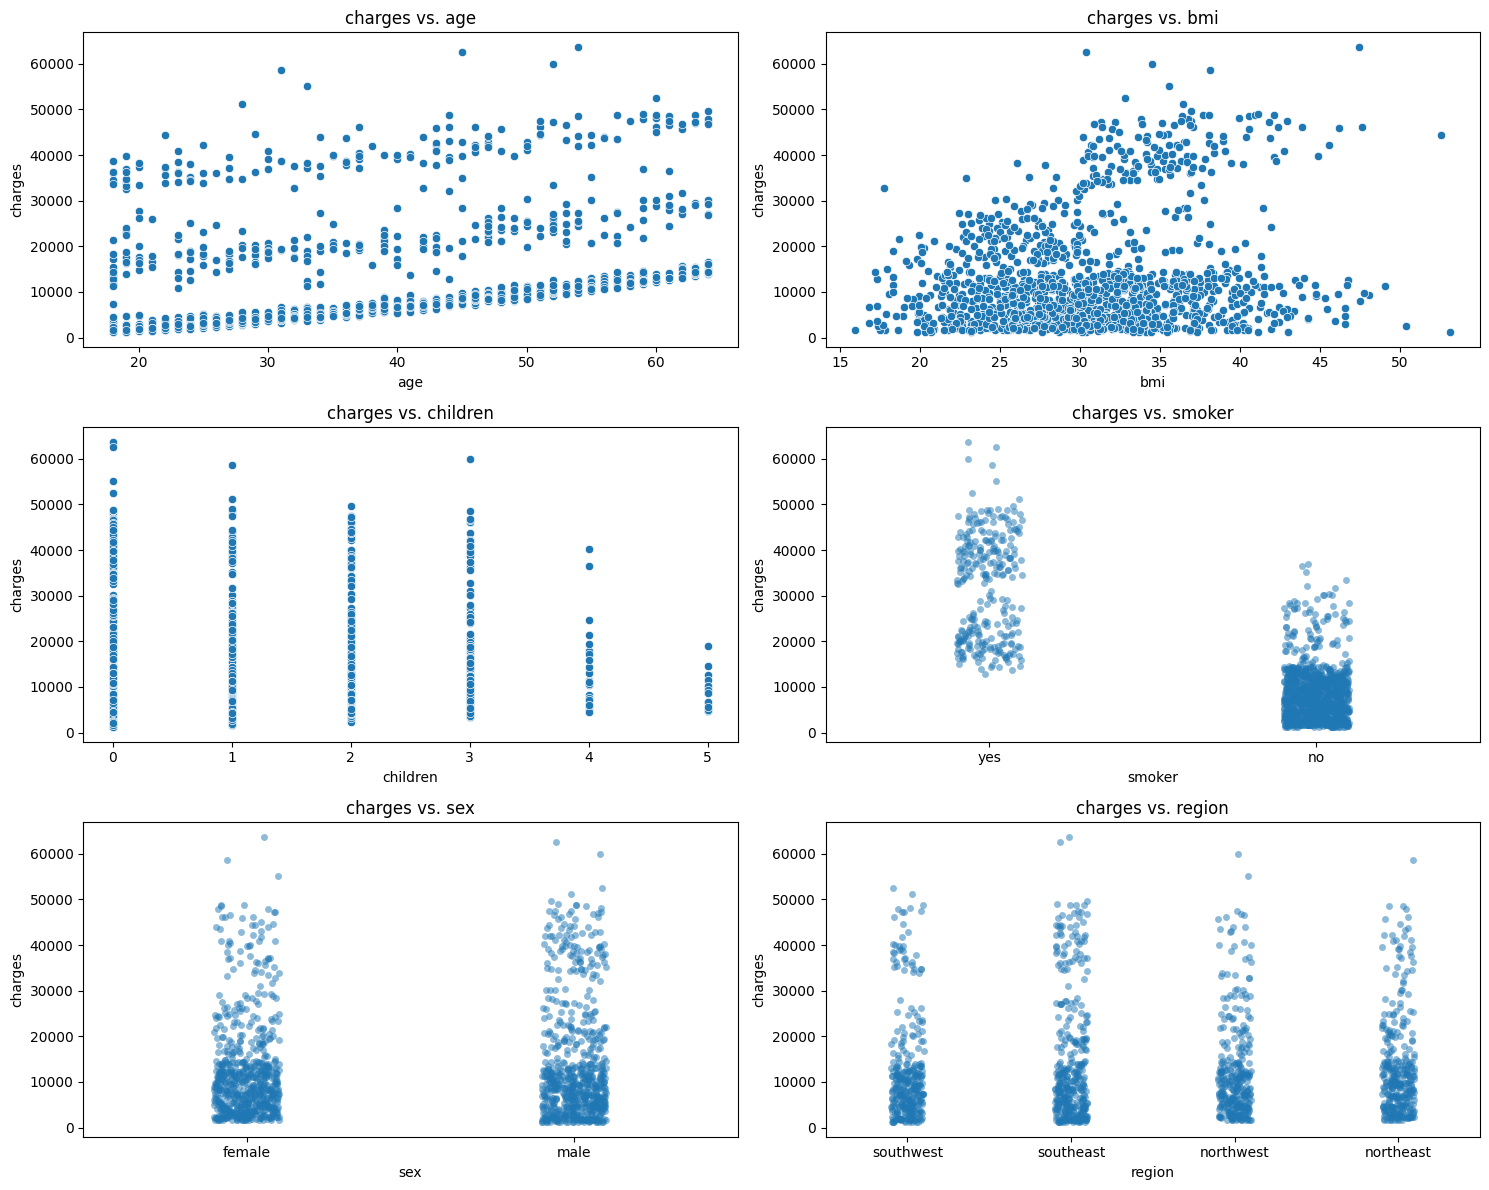

In [14]:
# Cria gráficos de dispersão e stripplots para examinar relações com 'charges'
fig, axs = plt.subplots(3, 2, figsize=(15, 12))

# Dispersão: idade vs. custo
sns.scatterplot(data=df, x="age", y="charges", ax=axs[0, 0])
axs[0, 0].set_title("charges vs. age")

# Dispersão: IMC vs. custo
sns.scatterplot(data=df, x="bmi", y="charges", ax=axs[0, 1])
axs[0, 1].set_title("charges vs. bmi")

# Dispersão: número de filhos vs. custo
sns.scatterplot(data=df, x="children", y="charges", ax=axs[1, 0])
axs[1, 0].set_title("charges vs. children")

# Stripplot: fumante vs. custo
sns.stripplot(data=df, x="smoker", y="charges", ax=axs[1, 1], jitter=True, alpha=0.5)
axs[1, 1].set_title("charges vs. smoker")

# Stripplot: sexo vs. custo
sns.stripplot(data=df, x="sex", y="charges", ax=axs[2, 0], jitter=True, alpha=0.5)
axs[2, 0].set_title("charges vs. sex")

# Stripplot: região vs. custo
sns.stripplot(data=df, x="region", y="charges", ax=axs[2, 1], jitter=True, alpha=0.5)
axs[2, 1].set_title("charges vs. region")

plt.tight_layout()
plt.show()


💡 Os gráficos de dispersão e stripplots mostram padrões importantes entre variáveis explicativas e os custos médicos (`charges`):

- `age`: tendência de aumento nos custos com a idade, reforçando sua relevância como variável contínua.
- `bmi`: disperso, mas com acúmulo de custos elevados para valores acima de 30 (obesidade).
- `children`: pouca relação visual direta.
- `smoker`: impacto evidente — fumantes concentram-se em uma faixa muito mais alta de `charges`.
- `sex`: pouca relação visual direta.
- `region`: variações discretas nos custos médios entre regiões.

Essas visualizações reforçam a necessidade de considerar **efeitos não lineares e interações entre variáveis**, especialmente ao escolher modelos como árvores de decisão e ensemble methods.


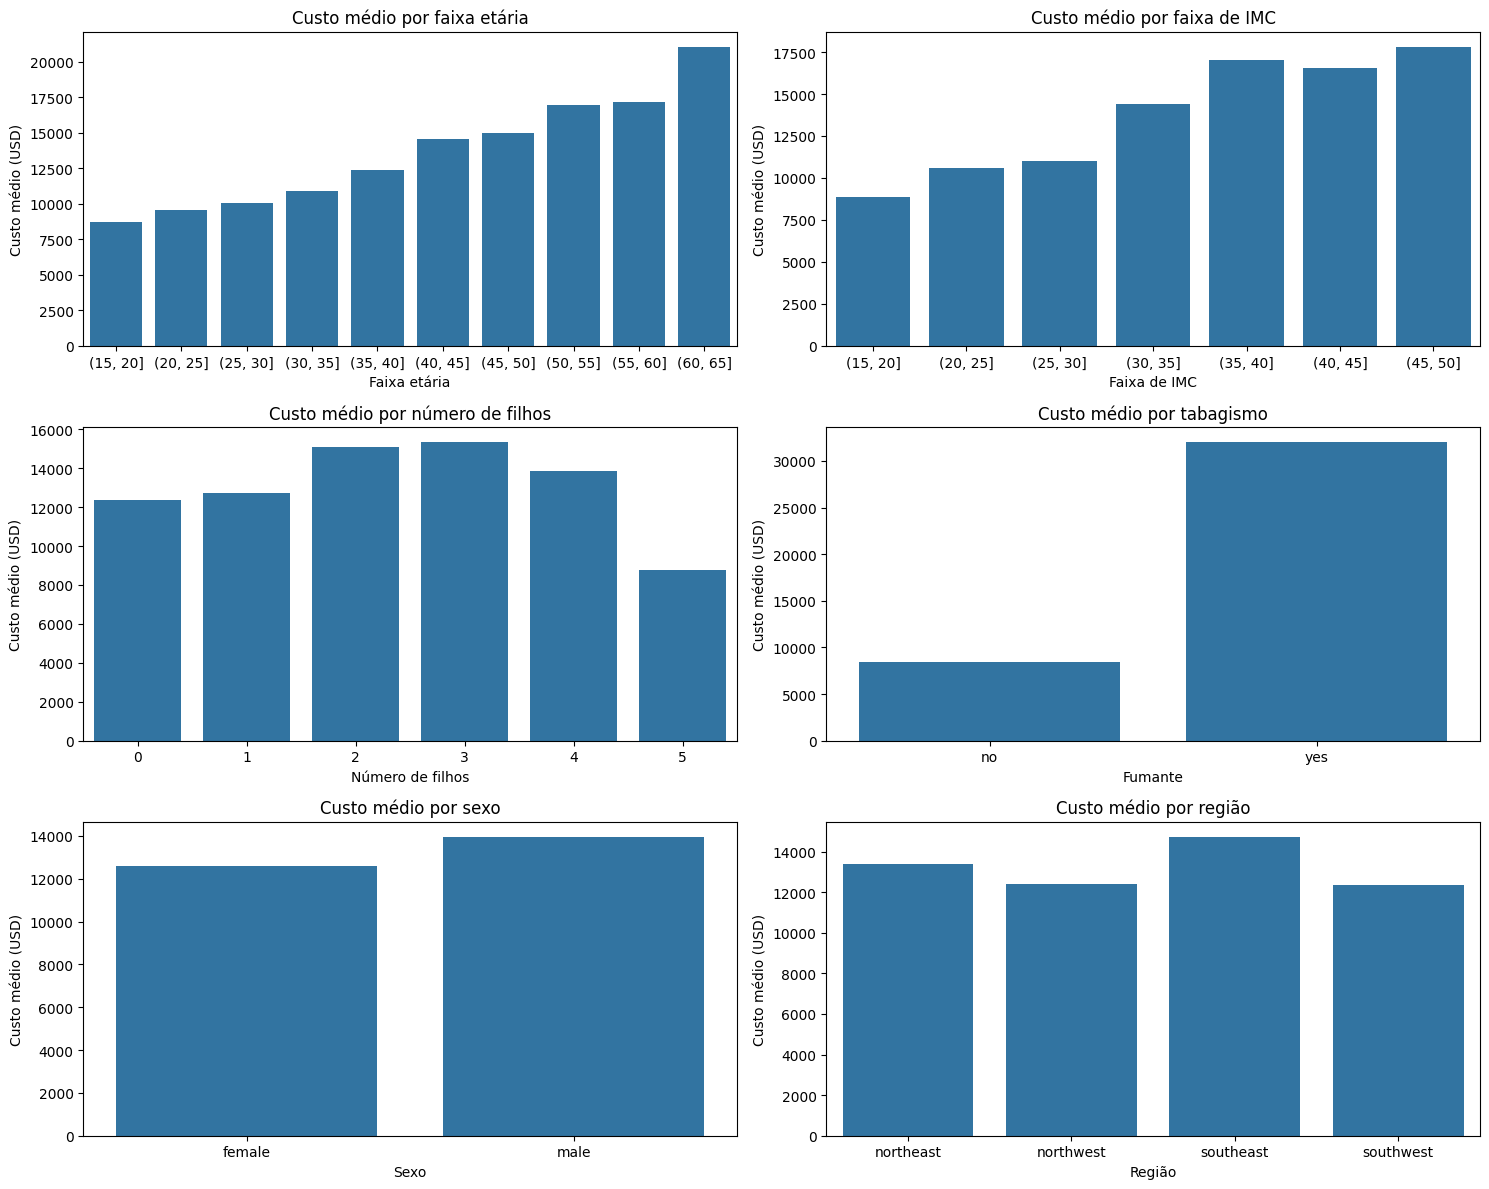

In [15]:
# Gera gráficos de barras para o custo médico médio por grupo de variáveis

df_viz = df.copy()
df_viz["age_group"] = pd.cut(df_viz["age"], bins=range(15, 70, 5))
df_viz["bmi_group"] = pd.cut(df_viz["bmi"], bins=range(15, 55, 5))

# Define colunas categóricas e rótulos para exibição
group_configs = {
    "age_group": ("Faixa etária", "Custo médio por faixa etária"),
    "bmi_group": ("Faixa de IMC", "Custo médio por faixa de IMC"),
    "children": ("Número de filhos", "Custo médio por número de filhos"),
    "smoker": ("Fumante", "Custo médio por tabagismo"),
    "sex": ("Sexo", "Custo médio por sexo"),
    "region": ("Região", "Custo médio por região")
}

# Define número de subplots dinamicamente com base na quantidade de variáveis
fig, axs = plt.subplots(3, 2, figsize=(15, 12))

for ax, (col, (xlabel, title)) in zip(axs.ravel(), group_configs.items()):
    grouped = df_viz.groupby(col, observed=True)["charges"].mean().reset_index()
    sns.barplot(data=grouped, x=col, y="charges", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Custo médio (USD)")

plt.tight_layout()
plt.show()


💡 A análise dos custos médicos médios por grupos revela padrões claros e úteis para interpretação:

- `age`: Há um aumento progressivo no custo médio conforme a faixa etária avança, refletindo o aumento de risco com o envelhecimento.
- `bmi`: A média de `charges` tende a subir a partir de IMCs acima de 30, indicando o impacto da obesidade.
- `children`: Embora o padrão não seja tão forte, há uma tendência leve de aumento com mais filhos.
- `smoker`: Diferença gritante — fumantes têm, em média, custos médicos muito superiores aos não fumantes.
- `sex`: Pequena diferença entre os grupos, mas consistente: indivíduos do sexo masculino tendem a apresentar médias ligeiramente superiores.
- `region`: As diferenças entre regiões são sutis, mas notáveis em alguns agrupamentos — o que pode indicar influências geográficas nos custos.

Essa visualização por média facilita a comunicação dos efeitos médios das variáveis de forma mais acessível.

# Pré-processamento de Dados

Nesta etapa, realizaremos transformações para preparar os dados para os modelos de regressão.


In [16]:
# Fazemos uma cópia do DataFrame original para aplicar codificações sem alterar os dados brutos
df_encoded = df.copy()

In [17]:
# Codifica as variáveis binárias 'sex' e 'smoker' manualmente.
df_encoded["sex"] = df_encoded["sex"].map({"female": 0, "male": 1})
df_encoded["smoker"] = df_encoded["smoker"].map({"no": 0, "yes": 1})

In [18]:
# Aplica codificação one-hot na variável 'region', criando colunas binárias para representar cada região.
df_encoded = pd.get_dummies(df_encoded, columns=["region"], drop_first=False)

In [19]:
# Converte colunas booleanas para inteiros (0 ou 1), garantindo compatibilidade com o modelos do statsmodels, como o OLS.
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes('bool').columns})

In [20]:
df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


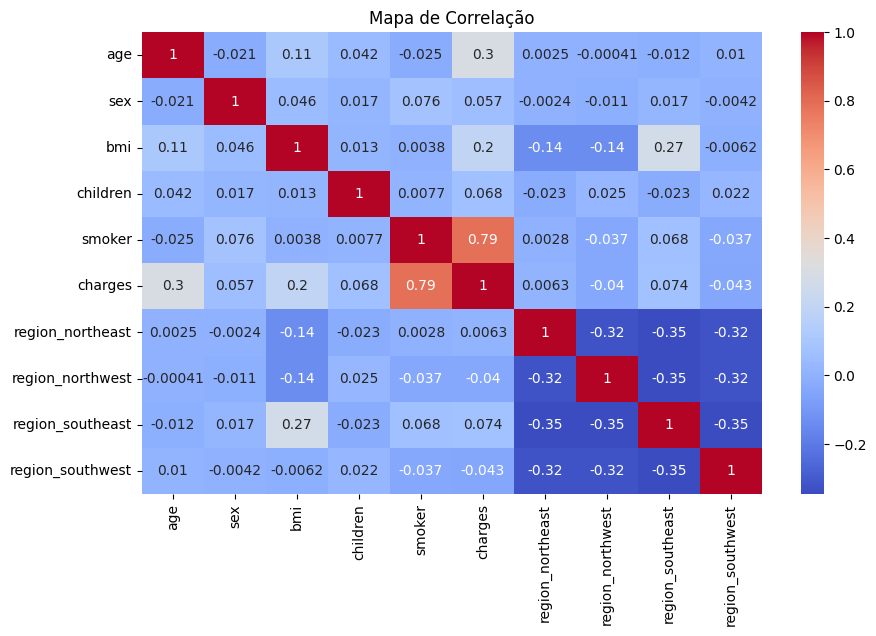

In [21]:
# Gera um mapa de calor com a correlação entre variáveis numéricas para identificar relações lineares com o custo médico.
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

💡 A matriz de correlação revela:

- `smoker` tem a maior correlação com  (0.79), indicando forte impacto nos custos médicos — possivelmente devido a maior risco associado ao tabagismo.
- `age` possui correlação moderada com  (0.30), o que faz sentido, já que idosos tendem a ter mais despesas médicas.
- `bmi` também mostra uma correlação positiva (0.20), o que também faz sentido, especialmente considerando casos de obesidade.
- `sex`, `children` e as variáveis de `region` têm correlações fracas (próximas de 0), sugerindo pouca influência direta em `charges`.

Essas informações ajudam a entender quais variáveis são mais relevantes para o modelo e quais podem ter influência limitada.

Mesmo assim, manter as regiões codificadas pode ajudar modelos mais complexos a capturar interações não-lineares.


In [22]:
# Cria duas versões do dataset: uma para modelos lineares e outra para modelos baseados em árvore.
df_tree = df_encoded.copy()
df_linear = df_encoded.drop(columns=["region_southeast"])

ℹ️ Ao aplicar one-hot encoding na variável categórica `region`, são criadas múltiplas colunas binária.

No entanto, manter todas essas colunas pode causar **multicolinearidade** em modelos lineares — uma condição em que variáveis altamente correlacionadas afetam negativamente os coeficientes da regressão.

Para evitar isso, removemos uma das colunas (no caso, `region_southwest`).

In [23]:
# Normaliza variáveis numéricas no dataset linear
scaler = StandardScaler()
numeric_features = ["age", "bmi", "children"]
df_linear[numeric_features] = scaler.fit_transform(df_linear[numeric_features])

ℹ️ Modelos como **Regressão Linear**, **Ridge** e **Lasso** são sensíveis à escala das variáveis.

Isso significa que atributos com valores maiores podem influenciar desproporcionalmente os coeficientes.

Para evitar esse problema, utilizamos o **StandardScaler**, que transforma as variáveis numéricas (`age`, `bmi`, `children`) para uma distribuição com média 0 e desvio padrão 1.  

Essa padronização garante que todos os atributos tenham a mesma importância inicial no processo de ajuste dos coeficientes.


In [24]:
df_linear.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southwest
0,-1.438764,0,-0.453320,-0.908614,1,16884.92400,0,0,1
1,-1.509965,1,0.509621,-0.078767,0,1725.55230,0,0,0
2,-0.797954,1,0.383307,1.580926,0,4449.46200,0,0,0
3,-0.441948,1,-1.305531,-0.908614,0,21984.47061,0,1,0
4,-0.513149,1,-0.292556,-0.908614,0,3866.85520,0,1,0


# Modelagem

Nesta etapa, definimos um dicionário chamado `models` contendo os algoritmos de regressão que serão avaliados. Cada entrada inclui:

- O modelo propriamente instanciado com seus parâmetros padrão (exceto o `random_state`, para garantir reprodutibilidade);
- O conjunto de dados correspondente, preparado de forma adequada:
  - Modelos lineares (`Linear Regression`, `Ridge`, `Lasso`) utilizam o `df_linear`, que passou por normalização e ajuste de multicolinearidade;
  - Modelos baseados em árvore (`Decision Tree`, `Random Forest`, `Gradient Boosting`) utilizam o `df_tree`, sem necessidade de normalização.

Essa separação permite comparar diferentes algoritmos de forma justa, utilizando os dados no formato mais apropriado para seu funcionamento.

In [25]:
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "data": df_linear
    },
    "Ridge": {
        "model": Ridge(),
        "data": df_linear
    },
    "Lasso": {
        "model": Lasso(),
        "data": df_linear
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "data": df_tree
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "data": df_tree
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "data": df_tree
    },
}

# Treinamento e Avaliação do Modelo

Nesta etapa, treinamos os modelos para prever os custos médicos com base nos dados de treino.
Depois, avaliamos seu desempenho em dados de teste — que os modelos ainda não conheciam.

Utilizamos métricas como **R²**, **MSE** e **RMSE** para medir a qualidade das previsões.

## Avaliação com Holdout (Treino/Teste)

Nesta etapa, usamos a estratégia **holdout** — uma divisão simples dos dados em treino e teste.

É uma abordagem eficiente para avaliação inicial, mas pode gerar resultados enviesados dependendo da divisão feita.

In [26]:
results_holdout = {} # Armazena as métricas por modelo
y_preds_holdout = {} # Armazena os valores previstos por modelo

for model_name, config in models.items():
    model = config["model"]
    df_base = config["data"]

    # Divide os dados em X (features) e y (target)
    X = df_base.drop("charges", axis=1)
    y = df_base["charges"]

    # Divide em conjunto de treino e teste (80/20), com random_state para reprodutibilidade
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Treina o modelo
    model.fit(X_train, y_train)

    # Gera predições para o conjunto de teste
    y_pred = model.predict(X_test)

    # Calcula métricas de avaliação
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Calcula RMSE manualmente (compatível com versões mais antigas do sklearn)

    # Salva as métricas no dicionário de resultados
    results_holdout[model_name] = {
        "R²": r2,
        "MSE": mse,
        "RMSE": rmse,
    }

    # Armazena predições e valores reais para análises gráficas posteriores
    y_preds_holdout[model_name] = y_pred

df_results_holdout = (pd.DataFrame(results_holdout).T.sort_values(by="R²", ascending=False))
display(df_results_holdout)

,R²,MSE,RMSE
Gradient Boosting,0.879116,1.876712e+07,4332.102865
Random Forest,0.863859,2.113577e+07,4597.365035
Linear Regression,0.783593,3.359692e+07,5796.284659
Lasso,0.783533,3.360622e+07,5797.087261
Ridge,0.783283,3.364508e+07,5800.438216
Decision Tree,0.693153,4.763760e+07,6901.999947


| **Métrica** | **Nome**                      | **Descrição**                                                   | **Interpretação**                                 |
| ----------- | ----------------------------- | --------------------------------------------------------------- | ------------------------------------------------- |
| `R²`        | Coeficiente de Determinação   | Mede o quanto da variação em `charges` é explicada pelo modelo. | Varia de 0 a 1. Quanto maior, melhor.             |
| `MSE`       | Erro Quadrático Médio         | Média dos erros elevados ao quadrado.                           | Penaliza fortemente grandes erros.                |
| `RMSE`      | Raiz do Erro Quadrático Médio | Raiz quadrada do MSE.                                           | Tem a mesma unidade da variável alvo (`charges`). |

💡 Provavelmente, o Gradient Boosting teve melhor performance porque:
- Captura relações não-lineares entre variáveis (como o impacto de ser fumante com IMC alto);
- Aprende interações complexas entre as variáveis de forma sequencial;
- Lida melhor com outliers nos custos (charges);
- Tem baixo viés e boa generalização, ideal para dados tabulares como esse;
- Funciona bem mesmo com um dataset pequeno, como o insurance.csv.

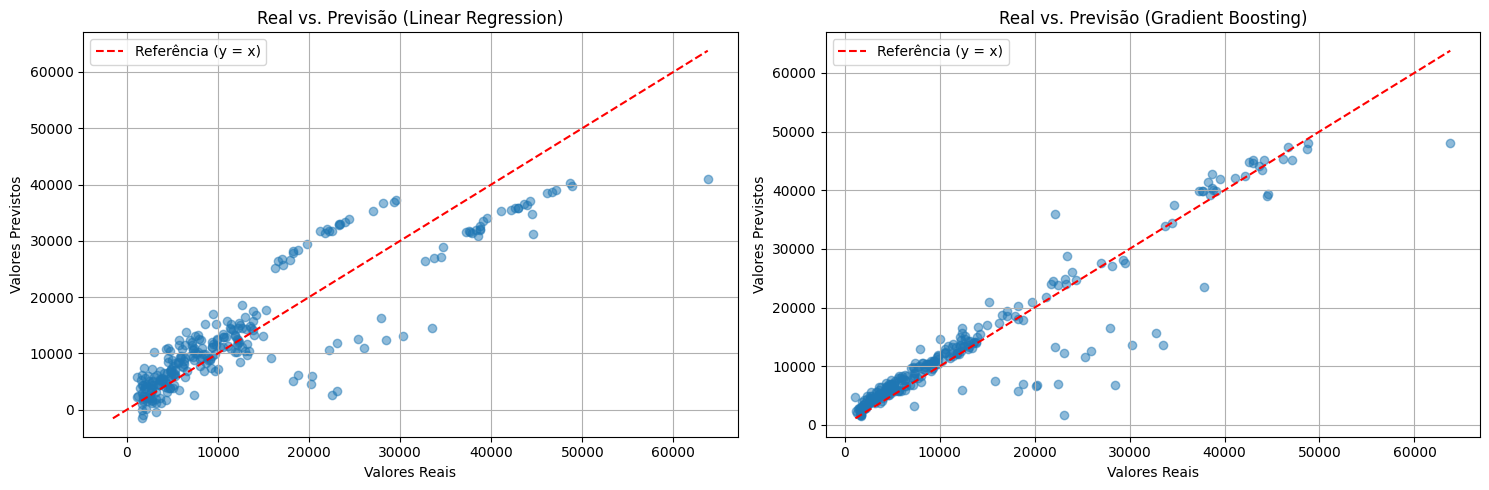

In [27]:
# Função para gerar gráfico de valores previstos vs. reais
def plot_prediction_vs_actual(model_name, ax, y_true, y_pred):
    ax.scatter(y_true, y_pred, alpha=0.5)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Referência (y = x)")
    
    ax.set_xlabel("Valores Reais")
    ax.set_ylabel("Valores Previstos")
    ax.set_title(f"Real vs. Previsão ({model_name})")
    ax.grid(True)
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_prediction_vs_actual("Linear Regression", axs[0], y_test, y_preds_holdout["Linear Regression"])
plot_prediction_vs_actual("Gradient Boosting", axs[1], y_test, y_preds_holdout["Gradient Boosting"])

plt.tight_layout()
plt.show()


## Avaliação com Validação Cruzada (K-Fold)

Nesta etapa, avaliamos os modelos utilizando validação cruzada do tipo **K-Fold**, que divide os dados em 5 partes e roda múltiplas rodadas de treino e teste.

Essa abordagem gera métricas mais estáveis e menos dependentes de uma única divisão dos dados.

In [28]:
# Define o esquema de validação cruzada K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados
results_table_kfold = {}

# Loop por todos os modelos
for model_name, config in models.items():
    model = config["model"]
    df_base = config["data"]

    X = df_base.drop("charges", axis=1)
    y = df_base["charges"]

    # Realiza validação cruzada com múltiplas métricas
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=kfold,
        scoring={"r2": "r2", "mse": "neg_mean_squared_error"},
        return_train_score=False
    )

    # Calcula as métricas agregadas
    r2_scores = cv_results["test_r2"]
    mse_scores = -cv_results["test_mse"]
    rmse_scores = np.sqrt(mse_scores)

    # Armazena as métricas no dicionário
    results_table_kfold[model_name] = {
        "Mean R²": np.mean(r2_scores),
        "R² Std": np.std(r2_scores),
        "Mean MSE": np.mean(mse_scores),
        "MSE Std": np.std(mse_scores),
        "Mean RMSE": np.mean(rmse_scores),
        "RMSE Std": np.std(rmse_scores),
    }

# Converte os resultados em DataFrame ordenado por desempenho
df_results_kfold = (
    pd.DataFrame(results_table_kfold)
    .T
    .sort_values(by="Mean R²", ascending=False)
    .reset_index()
)
df_results_kfold.rename(columns={"index": "Model"}, inplace=True)
display(df_results_kfold)


,Model,Mean R²,R² Std,Mean MSE,MSE Std,Mean RMSE,RMSE Std
0,Gradient Boosting,0.852094,0.033938,2.112260e+07,3.112306e+06,4583.456100,338.429710
1,Random Forest,0.835708,0.029606,2.355531e+07,2.071850e+06,4848.746166,212.053796
2,Ridge,0.740274,0.057122,3.699895e+07,3.066845e+06,6077.453657,251.998381
3,Lasso,0.740218,0.057729,3.699620e+07,3.122379e+06,6077.044143,256.392639
4,Linear Regression,0.740196,0.057778,3.699868e+07,3.128575e+06,6077.226921,256.898554
5,Decision Tree,0.713999,0.017933,4.178694e+07,5.322227e+06,6450.135664,427.426266


## Ajuste de Hiperparâmetros com GridSearchCV

Nesta etapa, buscamos os melhores hiperparâmetros para cada modelo utilizando validação cruzada (K-Fold) e a métrica R² como critério de avaliação.

Isso nos permite melhorar a performance dos modelos além do ajuste padrão, testando diferentes combinações de parâmetros.

In [29]:
# Dicionário com modelos e respectivos grids de hiperparâmetros
model_configs_grid = {
    "Linear Regression": {
        "estimator": models["Linear Regression"]["model"],
        "param_grid": {}
    },
    "Ridge": {
        "estimator": models["Ridge"]["model"],
        "param_grid": {
            "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    },
    "Lasso": {
        "estimator": models["Lasso"]["model"],
        "param_grid": {
            "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    "Decision Tree": {
        "estimator": models["Decision Tree"]["model"],
        "param_grid": {
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 3]
        }
    },
    "Random Forest": {
        "estimator": models["Random Forest"]["model"],
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_leaf": [1, 3],
            "max_features": ["sqrt", "log2"]
        }
    },
    "Gradient Boosting": {
        "estimator": models["Gradient Boosting"]["model"],
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.03, 0.05, 0.1],
            "max_depth": [2, 3, 4],
            "min_samples_leaf": [1, 3],
            "subsample": [0.8, 1.0]
        }
    }
}

# Avaliação dos modelos com GridSearchCV + validação cruzada
results_grid = []

for model_name, config in model_configs_grid.items():
    print(f"Ajustando hiperparâmetros: {model_name}")

    # Seleciona o DataFrame correto com base no modelo
    df_base = models[model_name]["data"]
    X = df_base.drop("charges", axis=1)
    y = df_base["charges"]

    # Executa a busca em grade com validação cruzada
    grid_search = GridSearchCV(
        estimator=config["estimator"],
        param_grid=config["param_grid"],
        scoring={"r2": "r2", "mse": "neg_mean_squared_error"},
        refit="r2",
        cv=kfold,
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    # Armazena os resultados principais
    results_grid.append({
        "Model": model_name,
        "Best R² (CV)": grid_search.best_score_,
        "Best Parameters": grid_search.best_params_,
        "Best Estimator": grid_search.best_estimator_
    })

# Cria o DataFrame ordenado por desempenho
df_results_grid = (
    pd.DataFrame(results_grid)
    .sort_values(by="Best R² (CV)", ascending=False)
    .reset_index(drop=True)
)
display(df_results_grid.drop(columns=["Best Estimator"]))


Ajustando hiperparâmetros: Linear Regression
Ajustando hiperparâmetros: Ridge
Ajustando hiperparâmetros: Lasso
Ajustando hiperparâmetros: Decision Tree
Ajustando hiperparâmetros: Random Forest
Ajustando hiperparâmetros: Gradient Boosting


,Model,Best R² (CV),Best Parameters
0,Gradient Boosting,0.857330,"{'learning_rate': 0.03, 'max_depth': 3, 'min_s..."
1,Random Forest,0.842615,"{'max_depth': 10, 'max_features': 'sqrt', 'min..."
2,Decision Tree,0.841747,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s..."
3,Lasso,0.740406,{'alpha': 10}
4,Ridge,0.740274,{'alpha': 1}
5,Linear Regression,0.740196,{}


# Validação Estatística

A análise com ferramentas estatísticas que permitam entender:

- A significância de cada variável preditora no modelo;
- A confiabilidade dos coeficientes estimados, por meio de p-values e intervalos de confiança;

Para isso, utilizamos a biblioteca `statsmodels`, que permite realizar uma regressão linear do tipo OLS (Ordinary Least Squares) com recursos avançados de interpretação estatística.

In [30]:
# Cria o modelo com fórmula (não precisa transformar todas as variáveis categóricas manualmente)
formula = 'charges ~ age + bmi + smoker + region + sex + children'

# Ajusta o modelo OLS
ols_model = smf.ols(formula=formula, data=df).fit()

# Mostra o sumário estatístico
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:43:41   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    

## Interpretação dos resultados do modelo OLS

* **R² = 0.751**

  * O modelo consegue explicar **75,1%** da variação nos custos médicos com base nas variáveis de entrada.
  * Isso indica que a maior parte dos fatores que influenciam os custos estão sendo capturados pelas variáveis selecionadas.

* **R² ajustado = 0.749**

  * Essa métrica ajusta o R² penalizando a inclusão de variáveis irrelevantes.
  * O fato de estar muito próximo do R² indica que as variáveis incluídas contribuem de fato para a explicação, sem overfitting.

* **F-statistic = 500.8 (p < 0.001)**

  * O teste F avalia se o modelo completo é estatisticamente melhor do que um modelo nulo (sem variáveis explicativas).
  * Com um valor de **p < 0.001**, temos forte evidência de que o conjunto de variáveis do modelo contribui significativamente para prever os custos médicos.
  * Em termos práticos, isso indica que as variáveis escolhidas agregam valor preditivo de forma conjunta, e não estamos apenas "chutando".

| Variável              | Coef.   | P-value (p) | Significativo? (p < 0.05) | Interpretação                                                               |
| --------------------- | ------- | ----------- | ------------------------- | --------------------------------------------------------------------------- |
| `smoker[T.yes]`       | 23,850  | 0.000       | ✅ Sim                    | Fumantes pagam em média \$23.850 a mais em custos médicos                   |
| `region[T.northwest]` | -353    | 0.459       | ❌ Não                    | Diferença não significativa em relação à região `northeast`                 |
| `region[T.southeast]` | -1,035  | 0.031       | ✅ Sim                    | Pessoas do `southeast` pagam em média \$1.035 a menos do que no `northeast` |
| `region[T.southwest]` | -960    | 0.045       | ✅ Sim                    | Pessoas do `southwest` pagam em média \$960 a menos do que no `northeast`   |
| `sex[T.male]`         | -131    | 0.693       | ❌ Não                    | Sexo não apresentou efeito estatisticamente significativo                   |
| `age`                 | +256.86 | 0.000       | ✅ Sim                    | Cada ano a mais de idade aumenta os custos médicos em \~\$256               |
| `bmi`                 | +339.19 | 0.000       | ✅ Sim                    | Cada ponto de IMC aumenta os custos médicos em \~\$339                      |
| `children`            | +475.50 | 0.001       | ✅ Sim                    | Cada filho adicional aumenta os custos médicos em \~\$475                   |


### 🤔 A variável `region` realmente melhora o modelo?

Geramos um novo modelo sem a variável `region`, e comparamos com o modelo completo usando ANOVA (Analysis of Variance):

In [31]:
# Modelo reduzido (sem region)
formula_reduced = 'charges ~ age + bmi + smoker + sex + children'
ols_model_reduced = smf.ols(formula=formula_reduced, data=df).fit()

# Comparação estatística entre os dois modelos
anova_results = anova_lm(ols_model_reduced, ols_model)
display(anova_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1332.0,4.907296e+10,0.0,NaN,NaN,NaN
1,1329.0,4.883953e+10,3.0,2.334312e+08,2.117343,0.096221


| Variável | P-value (p) | Significativo? (p < 0.05) | Interpretação                                                                |
| -------- | ----------- | ------------------------- | ---------------------------------------------------------------------------- |
| `region` | 0.096221    | ❌ Não                    | A região, como um todo, não apresentou efeito estatisticamente significativo |


### 🤔 Por que o coeficiente da regressão de `southeast` é negativo, sendo que a média de custos é a mais alta?

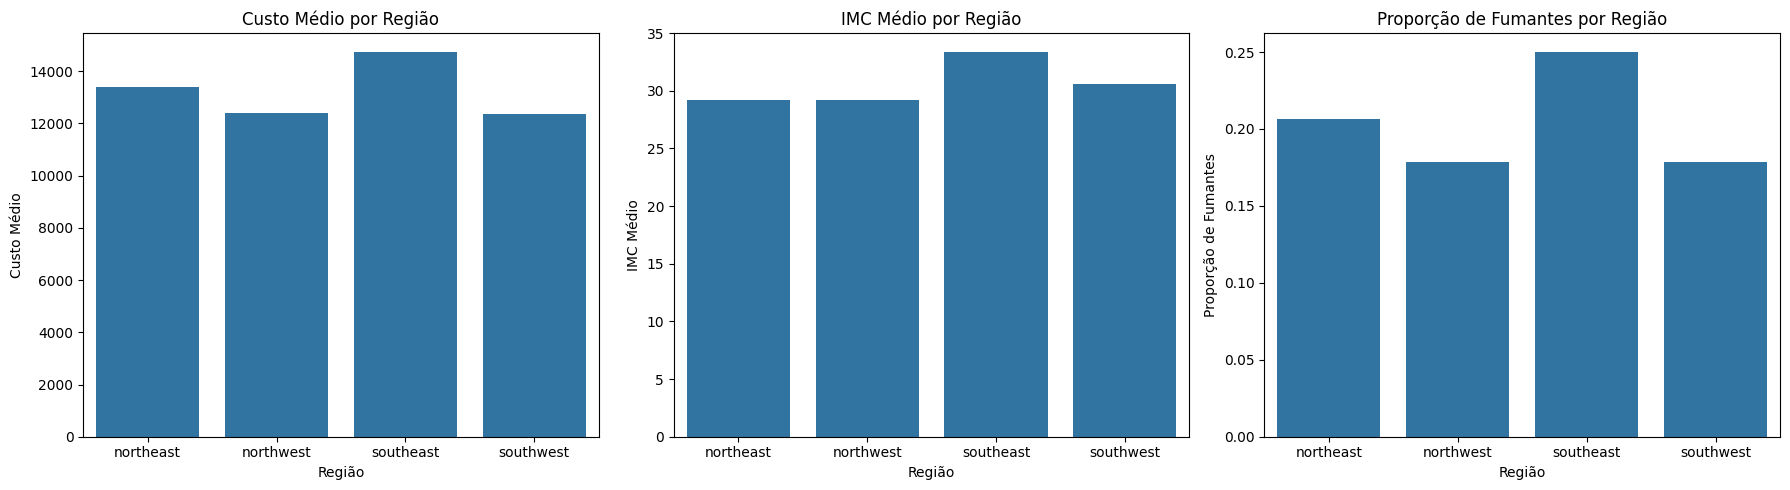

In [32]:
df_summary = (
    df.groupby("region")
    .agg(
        charges_mean=("charges", "mean"),
        bmi_mean=("bmi", "mean"),
        smoker_rate=("smoker", lambda x: (x == "yes").mean())
    )
    .reset_index()
)

column_labels = {
    "charges_mean": "Custo Médio",
    "bmi_mean": "IMC Médio",
    "smoker_rate": "Proporção de Fumantes"
}

def plot_bar(ax, data, x, y, title):
    sns.barplot(data=data, x=x, y=y, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Região")
    ax.set_ylabel(column_labels[y])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, y_col in zip(axs, column_labels.keys()):
    plot_bar(ax, df_summary, "region", y_col, title=column_labels[y_col] + " por Região")

plt.tight_layout()
plt.show()


A explicação está no que cada valor está medindo:

- A média simples mostra quanto, em média, as pessoas da região pagam — sem considerar idade, IMC ou se fumam.
- O coeficiente da regressão mostra o impacto da região quando comparamos pessoas com o mesmo perfil (mesma idade, IMC, tabagismo...).

A região `southeast` tem mais fumantes e pessoas com IMC mais alto. Isso puxa a média para cima! Mas quando o modelo "segura" essas variáveis (como se comparasse pessoas com o mesmo perfil em todas as regiões), ele entende que o custo alto não é por causa da região, mas por causa do perfil das pessoas que vivem lá.


<!-- ### 🧪 **Resumo das variáveis significativas**

* ✅ **`smoker`** é de longe a variável com **maior impacto e significância**.
* ✅ **`age`**, **`bmi`** e **`children`** também são estatisticamente significativas.
* ❌ **`sex`** e **`region_*`** **não têm efeito significativo** — ou seja, não explicam variações relevantes nos custos médicos nesse modelo.

---

### ⚠️ Considerações finais

* A estrutura do modelo é robusta, com boa explicação da variabilidade de `charges`.
* **Não há multicolinearidade perfeita**, dado que o modelo foi ajustado com One-Hot Encoding (removendo uma dummy).
* A ausência de significância de algumas variáveis pode indicar que elas:

  * Não afetam diretamente os custos médicos
  * Têm efeito indireto já absorvido por outras variáveis (como `smoker` ou `bmi`)
* Você poderia optar por **remover variáveis com p > 0.05** para simplificar o modelo sem perda de desempenho.

---

Se quiser, posso gerar um gráfico com os coeficientes significativos ou auxiliar na simplificação do modelo OLS. Deseja isso? -->


# Conclusão

Neste projeto, desenvolvemos um modelo de regressão preditiva para estimar os custos médicos cobrados por planos de saúde, com base em características demográficas e de estilo de vida dos pacientes. Ao longo das etapas de exploração, modelagem e validação, extraímos diversos insights relevantes:

- Não havia valores ausentes no conjunto de dados, o que simplificou o processo de pré-processamento dos dados.

- Na análise inicial com histogramas e boxplots, identificamos outliers relevantes em `charges` e `bmi`.

- A variável `children` apresentou forte desbalanceamento no gráfico de contagem, com a maioria dos registros concentrados entre 0 e 2 filhos. Como consequência, o modelo tende a aprender padrões mais confiáveis para esse grupo e generaliza com menor precisão para perfis com mais filhos.

- A variável `smoker` se destacou como a mais influente: os gráficos de distribuição mostraram que fumantes possuem custos significativamente mais altos do que não fumantes.

- Também percebemos que quanto maior o IMC (`bmi`) e a idade (`age`), maior tende a ser o custo do seguro. Esse padrão foi visualizado tanto nos histogramas quanto na matriz de correlação.

- Na fase de treinamento, os modelos apresentaram um R² mais alto na avaliação com holdout, mas o valor diminuiu ao aplicarmos validação cruzada (K-Fold) — o que indica que a primeira divisão pode ter sido otimista. Com o uso de `GridSearchCV` para ajuste de hiperparâmetros, o desempenho melhorou um pouco, refletindo um modelo mais robusto e bem ajustado.

- O melhor desempenho foi alcançado com o Gradient Boosting que obteve R² ≈ 0.86, mostrando boa capacidade preditiva e generalização!

- Na validação estatística com `statsmodels`, confirmamos a importância de `smoker`, `age` e `bmi`. A variável `smoker` apresentou um coeficiente estimado superior a R$ 23.000, com p-valor praticamente nulo, evidenciando seu forte impacto no custo do seguro.

- Por outro lado, a variável `region` teve impacto estatístico limitado. Através de um teste ANOVA entre modelos com e sem `region`, concluímos que ela pode ser excluída sem perda significativa de desempenho.


# Extra

## Pipeline

Para consolidar o melhor modelo identificado em um fluxo reprodutível e escalável, construímos uma pipeline completa.
Esta pipeline realiza o pré-processamento dos dados e aplica o modelo treinado de forma integrada.

- **Codificação ordinal** para variáveis binárias (`sex`, `smoker`);
- **One-hot encoding** para a variável categórica `region` (com exclusão da primeira categoria para evitar multicolinearidade);
- **Passagem direta** das variáveis numéricas (`age`, `bmi`, `children`);
- **Treinamento e predição** com o `GradientBoostingRegressor`, configurado com os melhores hiperparâmetros obtidos via GridSearchCV.

Essa abordagem permite encapsular todo o processo de preparação e modelagem em um único objeto, facilitando tanto a manutenção quanto a aplicação do modelo em novos dados.

In [33]:
# Definição das colunas
numeric_features = ['age', 'bmi', 'children']
binary_features = ['sex', 'smoker']
categorical_features = ['region']

# Pré-processador
preprocessor = ColumnTransformer(transformers=[
    ('encode_binary', OrdinalEncoder(dtype=int), binary_features),
    ('encode_categorical', OneHotEncoder(drop='first'), categorical_features),
    ('pass_numeric', 'passthrough', numeric_features)
])

# Pipeline final com o melhor modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        min_samples_leaf=1,
        subsample=1.0,
        random_state=42
    ))
])

# Divisão dos dados
X = df.drop(columns=['charges'])
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encode_binary',
                                                  OrdinalEncoder(dtype=<class 'int'>),
                                                  ['sex', 'smoker']),
                                                 ('encode_categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['region']),
                                                 ('pass_numeric', 'passthrough',
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,
                                           random_state=42))])

In [34]:
# Salva o pipeline treinado em um arquivo usando joblib
joblib.dump(pipeline, 'gradient_boosting_pipeline.pkl')

['gradient_boosting_pipeline.pkl']

In [35]:
# Carrega e usa o pipeline treinado do arquivo
pipeline_loaded = joblib.load('gradient_boosting_pipeline.pkl')

y_pred = pipeline_loaded.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.2f}')

R²: 0.8803
RMSE: 4311.35
